In [55]:
import pandas as pd
import numpy as np
#import shared
import json
from sklearn.preprocessing import LabelEncoder
import arviz as az
import pymc3 as pm
import seaborn as sns
import scipy

In [56]:
ve_or_ju = "ju"

In [57]:
runs_df = pd.read_csv(f'data/runs_{ve_or_ju}.tsv', delimiter="\t")


In [58]:
country_counts = runs_df["team_country"].value_counts()
top_country_counts = country_counts[country_counts > 100]
top_countries = top_country_counts.keys().tolist()
display(top_countries)

['FIN',
 'SWE',
 'NOR',
 'RUS',
 'LAT',
 'EST',
 'SUI',
 'GBR',
 'LTU',
 'GER',
 'DEN',
 'FRA']

In [59]:
runs_df["first_name"] = runs_df.name.str.split(" ", expand=True).iloc[:, 0]
labels, uniques = pd.factorize(runs_df.name.values)
hg = scipy.stats.rankdata(labels.ravel(),'dense').ravel()-1
display(len(hg))
display(len(runs_df))
runs_df['hier_group'] = hg
groups_2018 = runs_df.loc[runs_df.year == 2018, 'hier_group']
hier_groups = runs_df.loc[runs_df.year != 2018, 'hier_group']

76531

76531

In [60]:
runs_2018 = runs_df[runs_df.year == 2018]
# Temporarily remove 2018 in order to try predict it in other notebook
runs_df = runs_df[runs_df.year != 2018]
runs_df.head(5)

,name,year,team_id,team,team_country,pace,leg_nro,num_runs,first_name,hier_group
1,joni hirvikallio,2017,16,KOOVEE,FIN,5.762,1,6,joni,0
2,joni hirvikallio,2016,143,KOOVEE,FIN,6.251,6,6,joni,0
3,joni hirvikallio,2015,12,KOOVEE,FIN,5.843,5,6,joni,0
4,joni hirvikallio,2013,37,KOOVEE,FIN,5.796,1,6,joni,0
6,topi anjala,2017,1,KOOVEE,FIN,5.621,1,7,topi,1


In [61]:
ve_data = pd.read_csv(f'data/runs_ve.tsv', delimiter="\t")
ve_data["first_name"] = ve_data.name.str.split(" ", expand=True).iloc[:, 0]
ve_name_counts = ve_data["first_name"].value_counts()

In [62]:
def preprocess_and_make_np_pd_frames(runs_df, list_of_features, top_countries=None):
    
    def truncate_to_top_values(value, top_values):
        if value in top_values:
            return value
        else:
            return "OTHER"

    runs = runs_df.assign(leg=runs_df.leg_nro.astype(str))
    #truncate runs
    runs["runs"] = np.clip(runs.num_runs, 0, 8)
    #first name split
    runs["first_name"] = runs.name.str.split(" ", expand=True).iloc[:, 0]
    #set country to one of the top countries or other
    # make top countries if not provided
    if top_countries is None:
        country_counts = runs_df["team_country"].value_counts()
        top_country_counts = country_counts[country_counts > 100]
        top_countries = top_country_counts.keys().tolist()
    runs["c"] = runs.apply(lambda run: truncate_to_top_values(run["team_country"], top_countries), axis=1)
    #hierarchical group from full name
    labels, uniques = pd.factorize(runs.name.values)
    
    #ID transforms
    runs["team_id_log10"] = np.log10(runs.team_id)
    runs["team_id_log100"] = np.log(runs.team_id) / np.log(100)
    runs["team_id_square"] = np.square(runs.team_id)
    
    
    #make df with names from Venlat
    ve_data = pd.read_csv(f'data/runs_ve.tsv', delimiter="\t")
    ve_data["first_name"] = ve_data.name.str.split(" ", expand=True).iloc[:, 0]
    runs["ve_name"]=runs_df.first_name.isin(set(ve_data.first_name))
    runs['ve_name']=runs['ve_name']*1
    runs['pace']=np.log(runs['pace'])
    #select only the named features
    runs = runs[list_of_features]
    #explode leg and country
    numpy_frame_x = pd.get_dummies(data=runs, columns=["leg","c"], drop_first=True, sparse=True).drop(columns=["pace"]).values
    numpy_y = runs["pace"].values
    return numpy_frame_x, numpy_y, runs, labels

In [63]:
x, y, features, _ = preprocess_and_make_np_pd_frames(runs_df,['team_id_log10','c','runs','ve_name','leg','pace'])
display(features.head(5))
hier_dict = dict(list(zip(runs_df.name, hier_groups)))
display(hier_dict["topi anjala"])
display(x.shape)
display(y[1:5])
display(pd.get_dummies(data=features, columns=["leg","c"], drop_first=True, sparse=True).drop(columns=["pace"]).columns)

,team_id_log10,c,runs,ve_name,leg,pace
1,1.204120,FIN,6,0,1,1.751285
2,2.155336,FIN,6,0,6,1.832741
3,1.079181,FIN,6,0,5,1.765244
4,1.568202,FIN,6,0,1,1.757168
6,0.000000,FIN,7,0,1,1.726510


1

(64184, 20)

array([1.83274145, 1.76524436, 1.75716802, 1.72650958])

Index(['team_id_log10', 'runs', 've_name', 'leg_2', 'leg_3', 'leg_4', 'leg_5',
       'leg_6', 'leg_7', 'c_EST', 'c_FIN', 'c_GBR', 'c_GER', 'c_LAT', 'c_LTU',
       'c_NOR', 'c_OTHER', 'c_RUS', 'c_SUI', 'c_SWE'],
      dtype='object')

In [64]:
from shared import preprocess_features_ve
#features = preprocess_features_ve(runs_df,ve_data, top_countries)
#team_numbers = features[['team_id']]
#hier_groups = features[['name']]

#features.drop(columns=["team_id","name"],inplace=True)
#display(features.head(5))
#y = np.log(features['pace'].values.ravel())
# drop y and hierarchical group membership from predictor variables
#x_var_names = pd.get_dummies(features.drop(['pace'],axis=1), columns=["leg","c"], drop_first=True, sparse=True).columns
#x = pd.get_dummies(features.drop(['pace'],axis=1), columns=["leg","c"], drop_first=True, sparse=True).values
display(x.shape)
display(y.shape)
display(features.shape)
#display(x_var_names)

(64184, 20)

(64184,)

(64184, 6)

In [65]:
#display(np.sum(x!=x2))
#display(np.sum(features!=features2))

In [66]:
import sklearn
from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import joblib

In [67]:
np.random.seed(2019)
msk = (np.random.random(len(x)) < 0.8)
x_train = x[msk]
x_test = x[~msk]
features_test = features[~msk]

features = features[msk]
y_train = y[msk]
y_test = y[~msk]
groups_train = hier_groups[msk]
groups_test = hier_groups[~msk]

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2019)
display(x_train.shape)
display(x_test.shape)

(51318, 20)

(12866, 20)

In [68]:
display(x_train.shape)
display(y_train.shape)
display(x_test.shape)
display(features.shape)
display(features_test.shape)

(51318, 20)

(51318,)

(12866, 20)

(51318, 6)

(12866, 6)

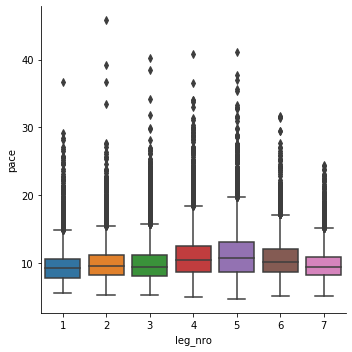

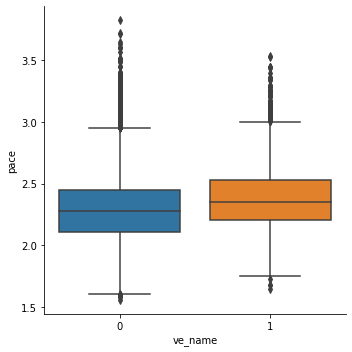

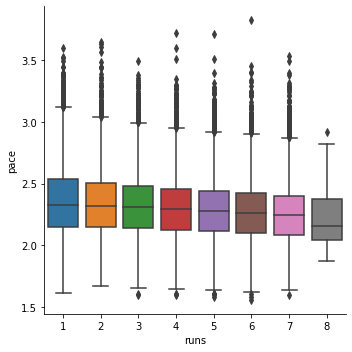

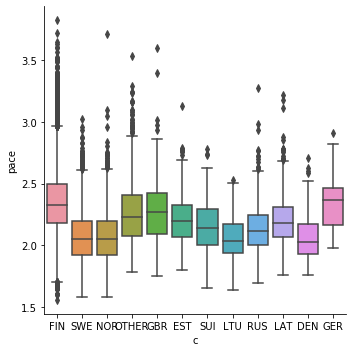

In [69]:
#glm_data.info()
#sns.scatterplot(features['team_id'],features['pace'],alpha=0.02)
sns.catplot(x='leg_nro',y='pace',data=runs_df, kind="box")
sns.catplot(x='ve_name',y='pace',data=features, kind="box")
sns.catplot(x='runs',y='pace',data=features, kind="box")
sns.catplot(x='c',y='pace',data=features, kind='box')

In [76]:
import matplotlib.pyplot as plt
def fit_and_test_model(model, x_train, x_test, y_train, y_test, fit_params={}):
    model.fit(x_train, y_train.ravel(), **fit_params)
    y_pred = np.exp(model.predict(x_test))
    print(f"Shapes: y_test={np.exp(y_test).shape} y_pred={y_pred.shape}")
    print("Mean squared error: %.3f" % mean_squared_error(np.exp(y_test), y_pred))
    print('Explained variance score: %.3f' % r2_score(np.exp(y_test), y_pred))
    
    plt.scatter(x_test[:,0], np.exp(y_test),  color='red', alpha=0.01)
    plt.scatter(x_test[:,0], y_pred, color='blue', alpha=0.01)
    plt.ylim(4, 20)
    plt.show()
    
    plt.scatter(np.exp(y_test), y_pred, color="green",alpha=0.2)
    plt.xlim(4,20)
    plt.xlabel("Original pace")
    plt.ylabel("Predicted pace")
    plt.show()
    return y_pred

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Shapes: y_test=(12866,) y_pred=(12866,)
Mean squared error: 5.466
Explained variance score: 0.365


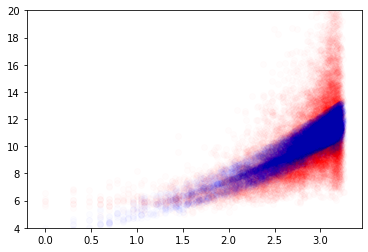

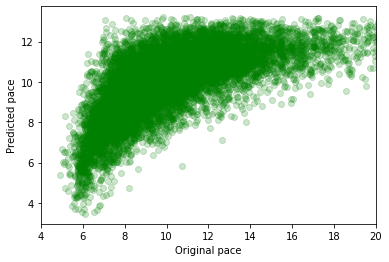

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
[ 0.3271347  -0.00999409 -0.00053925  0.04620988  0.0461985   0.12003246
  0.14796269  0.09868532  0.03150033  0.09692359  0.17640168  0.12174602
  0.1181231   0.09248766  0.01011678  0.06637417  0.10015819  0.05516731
  0.03115597  0.06211581]


In [77]:
#%%time
linear = linear_model.LinearRegression()
print(linear)
lm_pred = fit_and_test_model(linear, x_train, x_test, y_train, y_test)
print(linear)
print((linear.coef_))

In [78]:
#pd.DataFrame({'name':x_var_names, 'coef':linear.coef_})

      Iter       Train Loss   Remaining Time 
         1           0.0629            4.02m
         2           0.0584            3.71m
         3           0.0547            3.37m
         4           0.0517            3.21m
         5           0.0492            3.08m
         6           0.0471            3.06m
         7           0.0454            3.21m
         8           0.0439            3.26m
         9           0.0427            3.36m
        10           0.0417            3.40m
        20           0.0371            3.15m
        30           0.0357            2.84m
        40           0.0351            2.73m
        50           0.0348            2.57m
        60           0.0346            2.54m
        70           0.0345            2.44m
        80           0.0344            2.43m
        90           0.0343            2.36m
       100           0.0343            2.36m
       200           0.0338            2.11m
       300           0.0335            2.02m
       40

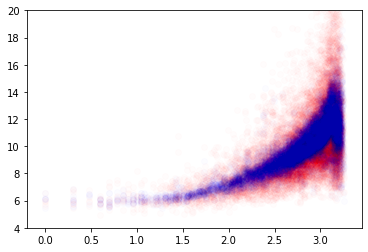

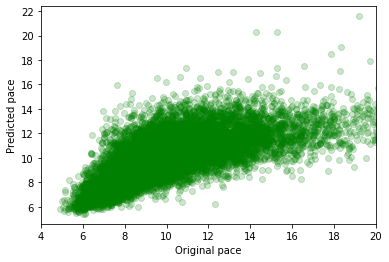

In [79]:
#%%time
gbr_num_estimators=7100
gbr = sklearn.ensemble.GradientBoostingRegressor(n_estimators=gbr_num_estimators, random_state=0, verbose=1)
#print(gbr)
gbr_pred = fit_and_test_model(gbr, x_train, x_test, y_train, y_test)
#print(f"feature_importances_: {gbr.feature_importances_}")
#gbr_features = pd.DataFrame({'feature':first_names.columns, 'importance': gbr.feature_importances_})
#gbr_features['feature'] = gbr_features['feature'].str.replace('top_first_name_','')
#display(gbr_features.sort_values(by="importance", ascending=False))
#
#joblib.dump(gbr, 'gbr_full.sav')

In [80]:
print(gbr)
print(type(gbr).__name__)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=7100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=1, warm_start=False)
GradientBoostingRegressor


In [81]:
gbr_num_estimators_quantile=int(gbr_num_estimators/2)

      Iter       Train Loss   Remaining Time 
         1           0.0568            2.34m
         2           0.0544            2.23m
         3           0.0523            2.19m
         4           0.0505            2.10m
         5           0.0490            2.06m
         6           0.0477            2.14m
         7           0.0466            2.15m
         8           0.0457            2.14m
         9           0.0449            2.11m
        10           0.0443            2.07m
        20           0.0413            1.91m
        30           0.0405            1.77m
        40           0.0401            1.71m
        50           0.0399            1.69m
        60           0.0398            1.66m
        70           0.0397            1.62m
        80           0.0397            1.60m
        90           0.0396            1.58m
       100           0.0396            1.55m
       200           0.0393            1.38m
       300           0.0392            1.24m
       40

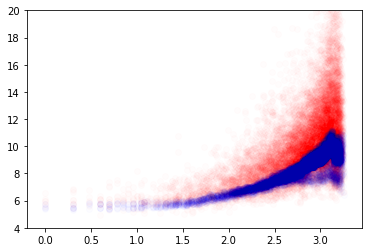

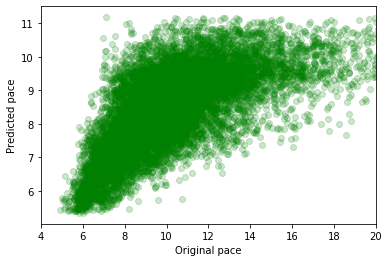

In [82]:
gbr_q_low = sklearn.ensemble.GradientBoostingRegressor(loss='quantile', alpha=0.159, n_estimators=gbr_num_estimators_quantile, random_state=0, verbose=1)
gbr_low_pred = fit_and_test_model(gbr_q_low, x_train, x_test, y_train, y_test)
#joblib.dump(gbr_q_low, 'gbr_q_low_full.sav')

      Iter       Train Loss   Remaining Time 
         1           0.0644            2.69m
         2           0.0624            2.45m
         3           0.0606            2.23m
         4           0.0590            2.10m
         5           0.0577            2.02m
         6           0.0565            2.02m
         7           0.0555            2.08m
         8           0.0547            2.14m
         9           0.0539            2.16m
        10           0.0533            2.13m
        20           0.0496            1.89m
        30           0.0483            1.79m
        40           0.0477            1.69m
        50           0.0474            1.66m
        60           0.0472            1.61m
        70           0.0470            1.58m
        80           0.0469            1.55m
        90           0.0469            1.53m
       100           0.0468            1.52m
       200           0.0464            1.35m
       300           0.0462            1.25m
       40

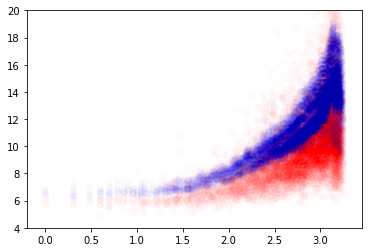

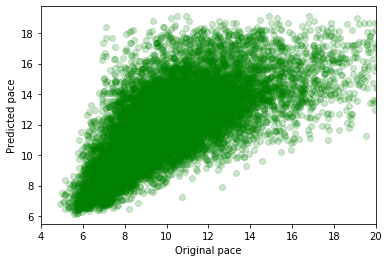

In [83]:
gbr_q_high = sklearn.ensemble.GradientBoostingRegressor(loss='quantile', alpha=0.841, n_estimators=gbr_num_estimators_quantile, random_state=0, verbose=1)
gbr_high_pred = fit_and_test_model(gbr_q_high, x_train, x_test, y_train, y_test)
#joblib.dump(gbr_q_high, 'gbr_q_high_full.sav')

In [84]:
gbr_preds = gbr.predict(pd.DataFrame(x_test))
gbr_q_low_preds = gbr_q_low.predict(pd.DataFrame(x_test))
gbr_q_high_preds = gbr_q_high.predict(pd.DataFrame(x_test))

In [85]:
gbr_q_pred_errors = pd.DataFrame({
    'q_low':np.exp(gbr_q_low_preds),
    'true':np.exp(y_test).ravel(), 
    'predicted':np.exp(gbr_preds), 
    'q_high':np.exp(gbr_q_high_preds), 
})

gbr_q_pred_errors["q_low_error"] = gbr_q_pred_errors.true < gbr_q_pred_errors.q_low
gbr_q_pred_errors["q_high_error"] = gbr_q_pred_errors.true > gbr_q_pred_errors.q_high
gbr_q_pred_errors["q_error"] = np.logical_or(gbr_q_pred_errors.q_low_error, gbr_q_pred_errors.q_high_error)

# Intentionally don't use log scale for calculation to get bigger std 
gbr_q_pred_errors["std"] = (gbr_q_pred_errors.q_high - gbr_q_pred_errors.q_low) / 2
gbr_q_pred_errors["std_correct"] = np.exp((gbr_q_high_preds - gbr_q_low_preds) / 2)
gbr_q_pred_errors["abs_error"] = np.abs(gbr_q_pred_errors.predicted - gbr_q_pred_errors.true)
gbr_q_pred_errors["abs_error_in_stds"] = gbr_q_pred_errors.abs_error / np.exp(gbr_q_pred_errors["std_correct"])

display(gbr_q_pred_errors.tail(15).round(3))
display(gbr_q_pred_errors.q_low_error.mean())
display(gbr_q_pred_errors.q_high_error.mean())
display(gbr_q_pred_errors.q_error.mean())
display(gbr_q_pred_errors["std"].mean())
display(gbr_q_pred_errors["std_correct"].mean())
display(gbr_q_pred_errors["abs_error_in_stds"].mean())

,q_low,true,predicted,q_high,q_low_error,q_high_error,q_error,std,std_correct,abs_error,abs_error_in_stds
12851,8.101,9.277,9.486,11.164,False,False,False,1.532,1.174,0.209,0.065
12852,7.213,7.944,7.942,9.634,False,False,False,1.210,1.156,0.002,0.001
12853,7.511,7.862,8.576,9.909,False,False,False,1.199,1.149,0.714,0.226
12854,7.738,7.467,9.424,11.149,True,False,True,1.706,1.200,1.957,0.589
12855,7.798,8.522,9.216,10.661,False,False,False,1.432,1.169,0.694,0.216
12856,7.170,8.514,8.506,9.891,False,False,False,1.360,1.174,0.008,0.002
12857,7.436,8.396,8.659,10.440,False,False,False,1.502,1.185,0.263,0.080
12858,7.537,12.509,9.893,11.055,False,True,True,1.759,1.211,2.616,0.779
12859,7.226,7.591,8.328,9.163,False,False,False,0.968,1.126,0.737,0.239
12860,7.074,9.680,8.887,9.757,False,False,False,1.341,1.174,0.793,0.245


0.1580133685683196

0.16632986165086275

0.3243432302191823

1.8012962176278582

1.1875886573039747

0.4501715125339023

In [86]:
np.exp(1.138)

3.1205210778255728

In [87]:
import theano as tt
predictors_shared = tt.shared(np.asarray(x_train,dtype=tt.config.floatX))
#obs = dat.iloc[0:n_limit]['pace'].values
obs = tt.shared(y_train)
#predictors_shared.shape

In [88]:
display(predictors_shared.get_value().shape)
display(obs.shape)
display(type(x_train))
display(type(predictors_shared))


(51318, 20)

Shape.0

numpy.ndarray

theano.tensor.sharedvar.TensorSharedVariable

In [89]:
import scipy
# GROUPS for hierarchical model
#J = len(np.unique(groups_train))

#uniques, labels = pd.factorize(groups_train.values.ravel())
#grp = uniques
grp = scipy.stats.rankdata(groups_train.ravel(),'dense').ravel()-1
#grp = scipy.stats.rankdata(groups_2018.ravel(),'dense').ravel()-1

display(len(grp))
J = len(np.unique(grp))
display(J)
grp = tt.shared(grp)

51318

23450

In [90]:

#HIERARCHICAL BAYESIAN MODEL WITH NUMPY ARRAYS
with pm.Model() as hier_model:
    #Hyper-priors
    mu_a = pm.Normal('mu_a', mu=0, tau=1e-6)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    
    #Random intercept
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=J)
    coef = pm.Normal('beta',mu=0, tau=1e-6, shape=predictors_shared.get_value().shape[1])
    sigma = pm.HalfCauchy('sigma', 15)
    
    b = pm.math.dot(predictors_shared, coef)
    theta = a[grp] + b
    outcome = pm.Normal('outcome', mu=theta, sd=sigma, observed=obs.ravel())
    np_trace = pm.sample(2500, chains=2, cores=4, tune=2500, random_seed=20179)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, beta, a, sigma_a, mu_a]
Sampling 2 chains: 100%|██████████| 10000/10000 [58:11<00:00,  2.69draws/s] 
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.04723746933729958, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9211361278251818, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12f4be320>,
      dtype=object)

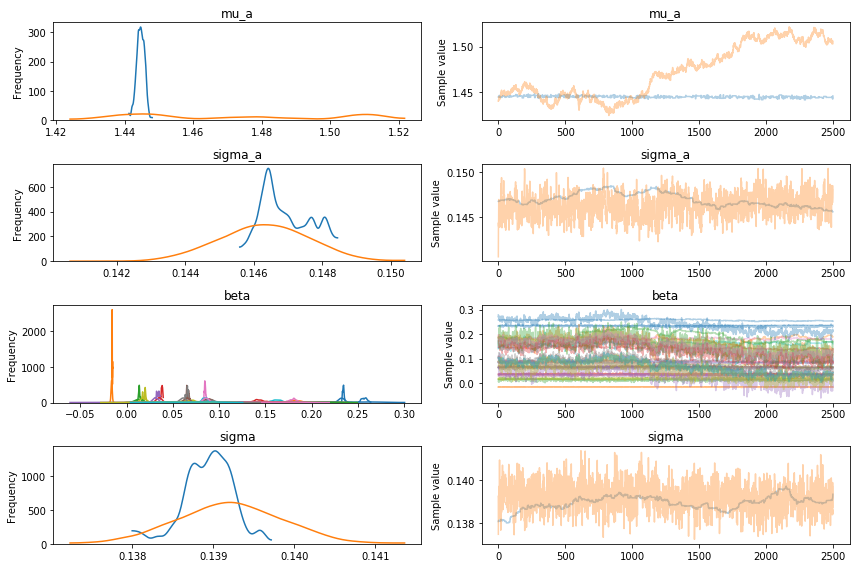

In [91]:
pm.traceplot(np_trace, varnames=['mu_a','sigma_a','beta','sigma'])

In [92]:
pm.summary(np_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_a,1.458273,0.024561,0.002447,1.435709,1.515451,3.320020,1.373357
a__0,1.286791,0.055225,0.002666,1.162061,1.405149,28.403456,1.010196
a__1,1.381223,0.060748,0.003542,1.266929,1.512726,16.544752,1.035006
a__2,1.442636,0.062850,0.004471,1.335267,1.562466,12.182028,1.015433
a__3,1.427463,0.078903,0.005510,1.293690,1.575345,7.244727,1.126678
a__4,1.418298,0.054245,0.002424,1.312497,1.554375,33.145713,1.018177
a__5,1.401501,0.055792,0.003710,1.317856,1.533461,3.037032,1.294024
a__6,1.400528,0.070681,0.004869,1.297940,1.559776,2.422120,1.379335
a__7,1.451297,0.056776,0.002826,1.318212,1.570601,40.586724,1.001030
a__8,1.412087,0.067284,0.004499,1.328651,1.575917,2.194294,1.414563


In [93]:
#STANDARD MODEL
with pm.Model() as st_model:
    #intercept
    a = pm.Normal("a",mu=0, sd=10)
    coef = pm.Normal('beta',mu=0, tau=1e-6, shape=predictors_shared.get_value().shape[1])
    sigma = pm.HalfCauchy('sigma', 15)
    b = pm.math.dot(predictors_shared, coef)
    theta = a + b
    outcome = pm.Normal('outcome', mu=theta, sd=sigma, observed=obs.ravel())
    glm_trace = pm.sample(2500, chains=2, cores=4, tune=2500, random_seed=2019)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, beta, a]
Sampling 2 chains: 100%|██████████| 10000/10000 [33:18<00:00,  3.30draws/s] 
The acceptance probability does not match the target. It is 0.718274648297357, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13c6d8828>,
      dtype=object)

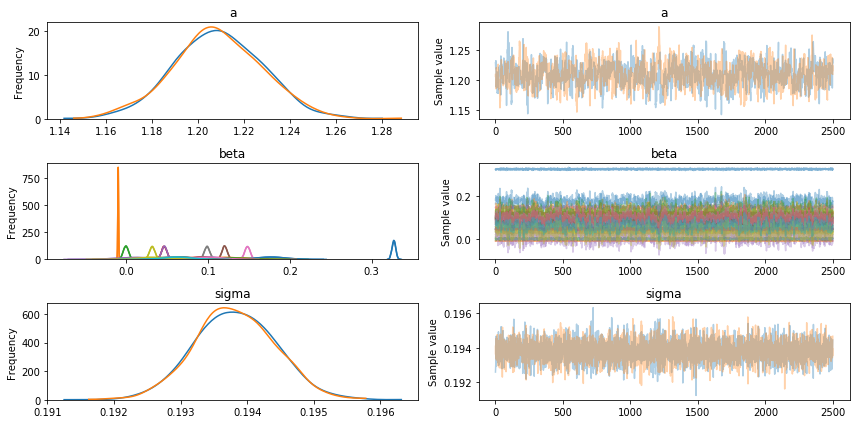

In [112]:
display(pm.traceplot(glm_trace))

In [113]:
display(pm.summary(glm_trace))

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,1.208751,0.019454,0.000681,1.167779,1.244781,703.825626,0.999800
beta__0,0.327100,0.002229,0.000032,0.322816,0.331431,4488.289027,0.999898
beta__1,-0.010005,0.000454,0.000007,-0.010888,-0.009127,4174.879434,0.999967
beta__2,-0.000624,0.003137,0.000044,-0.006716,0.005493,4595.056292,1.000192
beta__3,0.046225,0.003226,0.000075,0.039759,0.052229,1807.177966,0.999959
beta__4,0.046264,0.003181,0.000074,0.039881,0.052178,1858.937040,0.999914
beta__5,0.120078,0.003160,0.000068,0.113980,0.126247,1937.413981,0.999890
beta__6,0.148009,0.003202,0.000070,0.141705,0.154199,1977.535656,0.999826
beta__7,0.098694,0.003302,0.000071,0.092799,0.105603,2140.205405,1.000002
beta__8,0.031542,0.003275,0.000074,0.025206,0.037954,2007.621158,1.000027


In [94]:
J = len(np.unique(scipy.stats.rankdata(groups_test.ravel(),'dense').ravel()-1))
grp.set_value(scipy.stats.rankdata(groups_test.ravel(),'dense').ravel()-1)
#display(len(grp))

#out_of_sample = dat.iloc[(n_limit+1):(n_limit+1000)][variables].values
out_of_sample = np.asarray(x_test,dtype=tt.config.floatX)
#original_outcomes = dat.iloc[(n_limit+1):(n_limit+1000)]['pace'].values
original_outcomes = y_test
display(original_outcomes.shape)
display(original_outcomes[1:10])
display(out_of_sample[1:5,:])
predictors_shared.set_value(out_of_sample)
ppc = pm.sample_posterior_predictive(np_trace, model=hier_model, samples=500)
display(ppc['outcome'].sum(axis=0).shape)

display(ppc['outcome'].mean(axis=0)[1:10])


(12866,)

array([1.72650958, 1.96906848, 1.73023861, 1.91176226, 1.76917297,
       1.76421697, 1.76644166, 1.64325946, 1.90983876])

array([[0.        , 7.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.32221929, 7.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.56820172, 7.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.47712125, 7.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0

100%|██████████| 500/500 [00:05<00:00, 98.77it/s] 


(12866,)

array([1.45792369, 1.80535929, 1.84917174, 1.8392466 , 1.8385943 ,
       2.11396689, 1.83003751, 1.59754304, 1.4589843 ])

In [95]:
#bayes_features.set_value(features_test)
ppc_st = pm.sample_posterior_predictive(glm_trace, model=st_model, samples=500)
#display(ppc_st)
display(ppc_st['outcome'].mean(axis=0)[1:3])

100%|██████████| 500/500 [00:05<00:00, 97.44it/s] 


array([1.32839424, 1.79489279])

Shapes: y_test=(12866,) y_pred=(12866,)
Mean squared error: 7.621
Explained variance score: 0.115


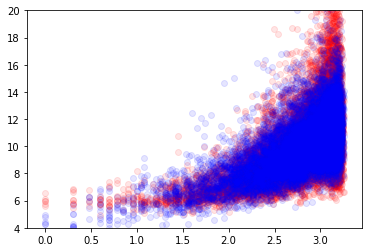

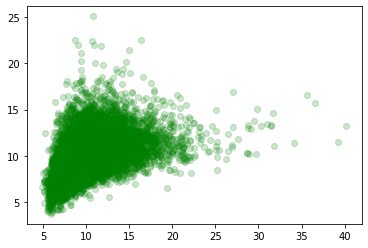

In [96]:
import matplotlib.pyplot as plt
y_pred = np.exp(ppc['outcome'].mean(axis=0))
print(f"Shapes: y_test={np.exp(original_outcomes).shape} y_pred={y_pred.shape}")
print("Mean squared error: %.3f" % mean_squared_error(np.exp(original_outcomes), y_pred))
print('Explained variance score: %.3f' % r2_score(np.exp(original_outcomes), y_pred))

plt.scatter((out_of_sample[:,0]), np.exp(original_outcomes),  color='red', alpha=0.1)
plt.scatter((out_of_sample[:,0]), y_pred, color='blue', alpha=0.1)
plt.ylim(4, 20)
plt.show()

plt.scatter(np.exp(original_outcomes), y_pred, color="green",alpha=0.2)
plt.show()

Shapes: y_test=(12866,) y_pred=(12866,)
Mean squared error: 5.471
Explained variance score: 0.365


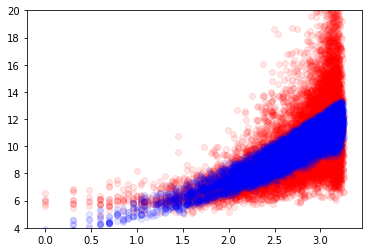

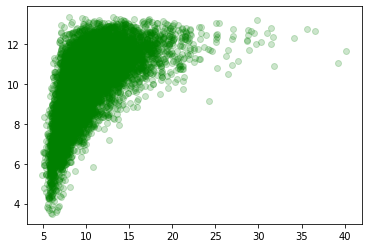

In [97]:
y_pred_st = np.exp(ppc_st['outcome'].mean(axis=0))
print(f"Shapes: y_test={np.exp(original_outcomes).shape} y_pred={y_pred_st.shape}")
print("Mean squared error: %.3f" % mean_squared_error(np.exp(original_outcomes), y_pred_st))
print('Explained variance score: %.3f' % r2_score(np.exp(original_outcomes), y_pred_st))

plt.scatter((out_of_sample[:,0]), np.exp(original_outcomes),  color='red', alpha=0.1)
plt.scatter((out_of_sample[:,0]), y_pred_st, color='blue', alpha=0.1)
plt.ylim(4, 20)
plt.show()

plt.scatter(np.exp(original_outcomes), y_pred_st, color="green",alpha=0.2)
plt.show()

# CV comparison

In [98]:
predictors_shared.set_value(np.asarray(x_train,dtype=tt.config.floatX))
#obs = dat.iloc[0:n_limit]['pace'].values
obs = y_train
grp.set_value(scipy.stats.rankdata(groups_train.ravel(),'dense').ravel()-1)
J = len(np.unique(grp))

hier_loo = pm.loo(np_trace,hier_model)
standard_bayes = pm.loo(glm_trace,st_model)
df_comp_LOO = pm.compare({hier_model: np_trace, st_model: glm_trace}, ic='LOO')
df_comp_LOO

/Users/tjpajala/.local/share/virtualenvs/jukola-o50OmWo4/lib/python3.6/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/Users/tjpajala/.local/share/virtualenvs/jukola-o50OmWo4/lib/python3.6/site-packages/pymc3/stats.py:299: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")
/Users/tjpajala/.local/share/virtualenvs/jukola-o50OmWo4/lib/pyth

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
0,-41417.2,12047.2,0,0.98,391.18,0,1
1,-22761.2,23.18,18656,0.02,427.2,285.34,0


In [99]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics.scorer import make_scorer
# for testing
models = [linear]
models = [gbr, linear]

def exp_scorer(x,y):
    x=np.exp(x)
    y=np.exp(y)
    return mean_squared_error(x,y)

scores = dict()
for mod in models:
    cv_score = cross_val_score(mod, x, y, cv=5, scoring=make_scorer(exp_scorer), verbose=0,error_score='raise')
    scores[type(gbr).__name__]=cv_score
    print("%s MSE: %f (+/- %f)" % (type(mod).__name__, cv_score.mean(), cv_score.std() * 2))

      Iter       Train Loss   Remaining Time 
         1           0.0583            2.48m
         2           0.0551            2.43m
         3           0.0525            2.49m
         4           0.0503            2.49m
         5           0.0485            2.51m
         6           0.0469            2.51m
         7           0.0457            2.53m
         8           0.0446            2.64m
         9           0.0437            2.66m
        10           0.0429            2.69m
        20           0.0393            2.53m
        30           0.0381            2.42m
        40           0.0375            2.37m
        50           0.0372            2.32m
        60           0.0370            2.26m
        70           0.0369            2.22m
        80           0.0368            2.18m
        90           0.0367            2.14m
       100           0.0366            2.12m
       200           0.0362            1.99m
       300           0.0358            1.94m
       40

# 2018 ennusteet

In [100]:
runs_2018['team_country']=runs_2018.team_country.astype('category', categories=features.c.astype('category').unique())
display(runs_2018.head(5))
cats = features.c.astype('category').unique()
display(cats)
display(runs_2018.team_country.unique())

#display(runs_2018.leg_nro.unique())
#display(runs_df.leg_nro.unique())

#display(runs_2018.team_country.unique()==runs_df.team_country.unique())

/Users/tjpajala/.local/share/virtualenvs/jukola-o50OmWo4/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3296: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  exec(code_obj, self.user_global_ns, self.user_ns)


,name,year,team_id,team,team_country,pace,leg_nro,num_runs,first_name,hier_group
0,joni hirvikallio,2018,2,KOOVEE,FIN,5.873,1,6,joni,0
5,topi anjala,2018,2,KOOVEE,FIN,5.882,2,7,topi,1
12,lauri sild,2018,2,KOOVEE,FIN,5.836,3,7,lauri,2
19,oleksandr kratov,2018,2,KOOVEE,FIN,5.703,4,3,oleksandr,3
22,kenny kivikas,2018,2,KOOVEE,FIN,5.603,5,7,kenny,4


[FIN, SWE, NOR, OTHER, GBR, ..., LTU, RUS, LAT, DEN, GER]
Length: 12
Categories (12, object): [FIN, SWE, NOR, OTHER, ..., RUS, LAT, DEN, GER]

[FIN, SWE, NOR, SUI, LTU, ..., GBR, NaN, LAT, EST, GER]
Length: 12
Categories (11, object): [FIN, SWE, NOR, SUI, ..., GBR, LAT, EST, GER]

In [101]:
x2, y2, features2, hier_groups_2018 = preprocess_and_make_np_pd_frames(runs_2018,['team_id_log10','c','runs','ve_name','leg','pace'], top_countries=top_countries)
#hier_groups_2018 = np.asarray([hier_dict[x] for x in runs_2018.name])
display(features2.head(5))
display(features2.shape)
display(x2.shape)
display(pd.get_dummies(features2, columns=["leg","c"]).columns)
display(x.shape[1]==x2.shape[1])
display(scipy.stats.describe(y2))
display(scipy.stats.describe(np.exp(y2)))

,team_id_log10,c,runs,ve_name,leg,pace
0,0.30103,FIN,6,0,1,1.770366
5,0.30103,FIN,7,0,2,1.771897
12,0.30103,FIN,7,0,3,1.764046
19,0.30103,FIN,3,0,4,1.740992
22,0.30103,FIN,7,0,5,1.723302


(12347, 6)

(12347, 20)

Index(['team_id_log10', 'runs', 've_name', 'pace', 'leg_1', 'leg_2', 'leg_3',
       'leg_4', 'leg_5', 'leg_6', 'leg_7', 'c_DEN', 'c_EST', 'c_FIN', 'c_GBR',
       'c_GER', 'c_LAT', 'c_LTU', 'c_NOR', 'c_OTHER', 'c_RUS', 'c_SUI',
       'c_SWE'],
      dtype='object')

True

DescribeResult(nobs=12347, minmax=(1.6286521313579045, 3.643489751815126), mean=2.324824458153651, variance=0.07160869870770616, skewness=0.42674989421217646, kurtosis=0.5740064018570794)

DescribeResult(nobs=12347, minmax=(5.0969999999999995, 38.224999999999994), mean=10.613461650603385, variance=9.606816997455981, skewness=1.6254348839513941, kurtosis=5.380108135354577)

In [102]:
# set hierarchical model params
predictors_shared.set_value(np.asarray(x2,dtype=tt.config.floatX))
#obs = dat.iloc[0:n_limit]['pace'].values
#obs = y2
grp.set_value(scipy.stats.rankdata(groups_2018.ravel(),'dense').ravel()-1)
J = len(np.unique(scipy.stats.rankdata(groups_2018.ravel(),'dense').ravel()-1))
display(x2.shape)
display(y2.shape)
display(J)

(12347, 20)

(12347,)

12341

In [103]:
#ST BAYES preds
ppc_st = pm.sample_posterior_predictive(glm_trace, model=st_model, samples=500)
pred_st = ppc_st['outcome'].mean(axis=0)
display(ppc_st['outcome'].mean(axis=0).shape)
display(ppc_st['outcome'].mean(axis=0)[1:5])
display(scipy.stats.describe(pred_st))
display(scipy.stats.describe(np.exp(pred_st)))

100%|██████████| 500/500 [00:04<00:00, 102.89it/s]


(12347,)

array([1.45862609, 1.46389602, 1.58508219, 1.5535486 ])

DescribeResult(nobs=12347, minmax=(1.2203379352607133, 2.6084863692588223), mean=2.3200237495606095, variance=0.03036024049724804, skewness=-1.4652576462490565, kurtosis=3.0676040437332874)

DescribeResult(nobs=12347, minmax=(3.3883325772217963, 13.57848248079708), mean=10.319348313441514, variance=2.589517114194406, skewness=-0.8265495403484595, kurtosis=0.7163100193269534)

In [104]:
#HIER_BAYES preds
ppc = pm.sample_posterior_predictive(np_trace, model=hier_model, samples=500)
pred_hier = ppc['outcome'].mean(axis=0)
display(ppc['outcome'].mean(axis=0).shape)
display(ppc['outcome'].mean(axis=0)[1:5])
display(scipy.stats.describe(pred_hier))
display(scipy.stats.describe(np.exp(pred_hier)))

100%|██████████| 500/500 [00:04<00:00, 101.66it/s]


(12347,)

array([1.56342269, 1.79091479, 1.79969978, 1.72284525])

DescribeResult(nobs=12347, minmax=(1.3152993009700518, 3.252645997612591), mean=2.3089366308866097, variance=0.04749967132194636, skewness=-0.38282577461331735, kurtosis=0.622121984117725)

DescribeResult(nobs=12347, minmax=(3.7258659736845394, 25.858671457720934), mean=10.299382612641118, variance=4.8150308502768615, skewness=0.4479159025352027, kurtosis=1.2407716661822956)

In [105]:
#GBR preds
pred_gbr = gbr.predict(x2)
#LINEAR preds
pred_linear = linear.predict(x2)

#LOW and HIGH limits
perc_gbr_low = gbr_q_low.predict(x2)
perc_gbr_high = gbr_q_high.predict(x2)
perc_gbr = np.column_stack((perc_gbr_low, perc_gbr_high))
display(perc_gbr.shape)
display(perc_gbr[1:3,:])
#display(sum((pred_linear - y2)**2))
perc_linear = np.column_stack((pred_linear - 1.96*np.sqrt(1/(len(x2)-2) * sum((pred_linear - y2)**2)),  pred_linear + 1.96*np.sqrt(1/(len(x2)-2) * sum((pred_linear - y2)**2))))
display(perc_linear.shape)
display(perc_linear[1:3,:])
perc_hier=np.percentile(ppc['outcome'],q=(5,95),axis=0).T
display(perc_hier.shape)
display(perc_hier[1:3,:])
perc_st=np.percentile(ppc_st['outcome'],q=(5,95),axis=0).T
display(perc_st.shape)
display(perc_st[1:3,:])

(12347, 2)

array([[1.75569515, 1.87463306],
       [1.75812403, 1.89958174]])

(12347, 2)

array([[1.08820988, 1.83071945],
       [1.0881985 , 1.83070807]])

(12347, 2)

array([[1.32754885, 1.79040105],
       [1.55058698, 2.02513059]])

(12347, 2)

array([[1.15538181, 1.7698399 ],
       [1.14334554, 1.81213175]])

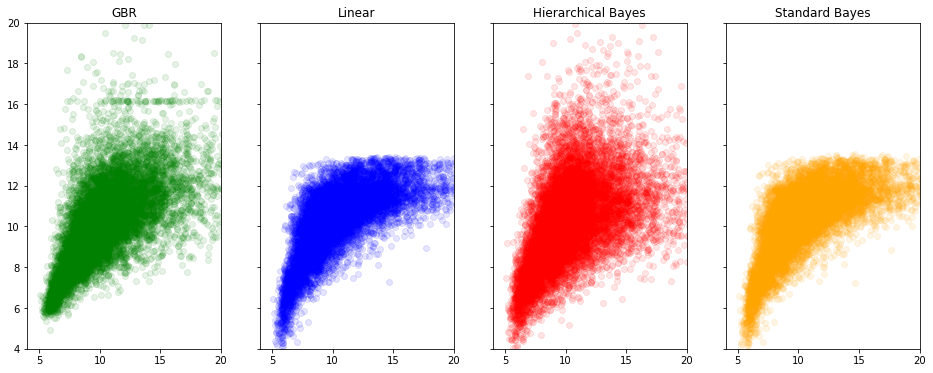

In [106]:
preds = [pred_gbr, pred_linear, pred_hier,pred_st]
lows = [perc_gbr[:,0],perc_linear[:,0],perc_hier[:,0]]
highs = [perc_gbr[:,1],perc_linear[:,1],perc_hier[:,1]]
colors = ['green','blue','red',"orange"]
titles = ['GBR','Linear','Hierarchical Bayes','Standard Bayes']
fig, axs = plt.subplots(1,len(preds), figsize=(16,6),sharey=True, sharex=True)

for i in range(0,len(preds)):
    axs[i].scatter(np.exp(y2), np.exp(preds[i]), color=colors[i], alpha=0.1)
    axs[i].set_xlim([4,20])
    axs[i].set_ylim([4,20])
    axs[i].set_title(titles[i])
#plt.scatter(np.exp(y2), pred_gbr, color="green",alpha=0.05)
#plt.scatter(np.exp(y2), pred_linear, color="blue",alpha=0.05)
#plt.scatter(np.exp(y2), pred_bayes, color="red",alpha=0.05)
plt.show()

# Individual view

In [107]:
runs_2018["pred_hier"]=np.exp(pred_hier)
runs_2018["pred_st"]=np.exp(pred_st)
runs_2018["pred_gbr"]=np.exp(pred_gbr)
runs_2018["pred_linear"]=np.exp(pred_linear)
runs_2018["perc_hier_5"],runs_2018["perc_hier_95"]=np.exp(perc_hier.T)
runs_2018["perc_st_5"],runs_2018["perc_st_95"]=np.exp(perc_st.T)
runs_2018["perc_linear_5"],runs_2018["perc_linear_95"]=np.exp(perc_linear.T)
runs_2018["perc_gbr_5"],runs_2018["perc_gbr_95"]=np.exp(perc_gbr.T)


In [108]:
display(runs_2018.loc[runs_2018.team=="REAKTOR INNOVATIONS",
                      ["name","team","leg_nro","num_runs","pace","pred_hier","pred_st","pred_gbr","pred_linear",
                      "perc_hier_5","perc_hier_95","perc_st_5","perc_st_95","perc_linear_5","perc_linear_95","perc_gbr_5","perc_gbr_95"]])

,name,team,leg_nro,num_runs,pace,pred_hier,pred_st,pred_gbr,pred_linear,perc_hier_5,perc_hier_95,perc_st_5,perc_st_95,perc_linear_5,perc_linear_95,perc_gbr_5,perc_gbr_95
15893,mikko peltonen:REAKTOR INNOVATIONS,REAKTOR INNOVATIONS,1,7,8.448,8.808839,8.703679,8.287097,8.810512,6.918755,11.169002,6.534744,11.837210,6.078092,12.771298,7.414160,9.787158
15904,pasi huhtiniemi,REAKTOR INNOVATIONS,2,7,8.619,8.158754,9.237786,8.651772,9.227198,6.485770,10.137495,6.706629,12.842082,6.365550,13.375307,7.689408,9.977495
15911,joni freeman,REAKTOR INNOVATIONS,3,7,7.430,11.351407,9.115677,8.784122,9.227093,9.067470,14.127101,6.792030,12.629476,6.365478,13.375154,7.753751,10.137415
15918,tuomas kareinen,REAKTOR INNOVATIONS,4,7,10.131,8.688798,9.897052,9.215661,9.934147,7.038039,11.004980,7.240957,13.905247,6.853252,14.400066,7.846017,11.095758
15925,janne vaittinen,REAKTOR INNOVATIONS,5,3,12.852,10.689142,10.541209,9.569652,10.626441,8.377103,13.464386,7.704621,14.548112,7.330843,15.403583,8.067411,12.025431
15928,olavi kanerva,REAKTOR INNOVATIONS,6,1,7.406,9.766946,10.389112,9.879603,10.325282,7.625778,12.347889,7.523812,14.094810,7.123083,14.967036,8.271649,11.931965
15929,jyri kytömäki,REAKTOR INNOVATIONS,7,5,11.219,9.460387,9.334175,8.836502,9.276034,7.479182,11.974905,6.971705,12.577555,6.399240,13.446097,7.728766,10.489825
34885,antti-ville jokela,REAKTOR INNOVATIONS,1,2,10.156,8.793744,10.793422,11.421509,10.806089,7.031327,10.896203,7.706639,15.197305,7.454777,15.663992,9.581603,14.283760
34887,karri-pekka laakso,REAKTOR INNOVATIONS,2,6,12.029,10.588250,10.945836,12.130113,10.873659,8.421323,13.408136,7.954002,15.275274,7.501391,15.761939,9.626444,14.140335
34893,oskari pirttikoski,REAKTOR INNOVATIONS,3,7,15.230,11.509443,10.802758,11.850214,10.765406,9.113334,14.376316,7.997835,14.536693,7.426711,15.605019,9.565734,14.332429


14

14

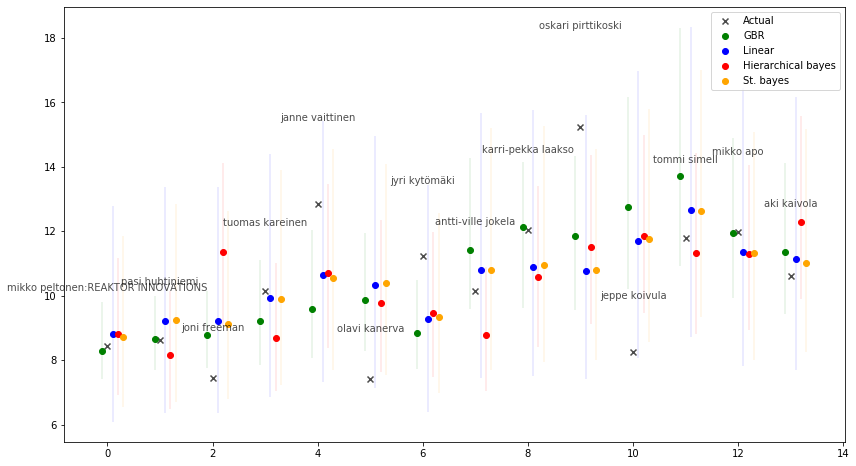

In [109]:
def plot_individual_rows(filtered_df, alpha=1):
    fig, ax = plt.subplots(figsize=(14,8))
    ax.scatter(x=np.arange(0,len(filtered_df)), y=filtered_df.pace, color="black", alpha=0.7, marker="x",label="Actual")
    for n in range(0, len(filtered_df.name.values)):
        ax.text(x=n, y=filtered_df.pace.values[n]*1.2, s=str(filtered_df.name.values[n]), alpha=0.7, horizontalalignment="center")
    ax.scatter(x=np.arange(0,len(filtered_df))-0.1, y=filtered_df.pred_gbr, alpha=alpha, color="green",label="GBR")
    ax.scatter(x=np.arange(0,len(filtered_df))+0.1, y=filtered_df.pred_linear, alpha=alpha, color="blue",label="Linear")
    ax.scatter(x=np.arange(0,len(filtered_df))+0.2, y=filtered_df.pred_hier, alpha=alpha, color="red", label="Hierarchical bayes")
    ax.scatter(x=np.arange(0,len(filtered_df))+0.3, y=filtered_df.pred_st, alpha=alpha, color="orange", label="St. bayes")
    ax.vlines(np.arange(0, len(filtered_df))-0.1, ymin=filtered_df.perc_gbr_5, ymax=filtered_df.perc_gbr_95, color="green",alpha=0.1)
    ax.vlines(np.arange(0, len(filtered_df))+0.1, ymin=filtered_df.perc_linear_5, ymax=filtered_df.perc_linear_95, color="blue",alpha=0.1)
    ax.vlines(np.arange(0, len(filtered_df))+0.2, ymin=filtered_df.perc_hier_5, ymax=filtered_df.perc_hier_95, color="red",alpha=0.1)
    ax.vlines(np.arange(0, len(filtered_df))+0.3, ymin=filtered_df.perc_st_5, ymax=filtered_df.perc_st_95, color="orange",alpha=0.1)
    ax.legend()
    plt.show()
    return None

display(len(np.arange(0,len(runs_2018[runs_2018.team=="REAKTOR INNOVATIONS"]))))
display(len(runs_2018.loc[runs_2018.team=="REAKTOR INNOVATIONS","pace"]))
plot_individual_rows(runs_2018[runs_2018.team=="REAKTOR INNOVATIONS"])

In [110]:
STOP_HERE

NameError: name 'STOP_HERE' is not defined